# Preprocessing Summary Data

In [79]:
%load_ext autoreload
%autoreload 2
PROJ_HOME='/Users/keemsunguk/Projects/analyst_performance/'
import sys
sys.path.append(PROJ_HOME)
from datetime import datetime
from pathlib import Path
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
from tqdm import tqdm

In [5]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from googletrans import Translator

In [16]:
from arum.preprocessing import fix_price, get_author_production, clean_recommendations, change_col_names, build_labels
from arum.preprocessing import check_report_date, group_by_month
from arum.lookups.column_names import new_col_names

In [4]:
data_dir = Path(PROJ_HOME+'/data')

In [6]:
nlp = spacy.load("en_core_web_lg")

In [7]:
translator = Translator(service_urls=[
      'translate.google.com',
      'translate.google.co.kr',
    ])

# Preprocessing

In [8]:
sentiment_df = pd.read_pickle(PROJ_HOME+'/data/sentiment_pub_trade.pkl')

In [9]:
get_author_production(sentiment_df)

{'이동헌': 354,
 '박종선': 346,
 '한상원': 280,
 '김경민': 271,
 '조미진': 268,
 '박상준': 258,
 '한유정': 257,
 '이상헌': 255,
 '김현용': 255,
 '정태준': 249,
 '박은정': 243,
 '안재민': 241,
 '정홍식': 237,
 '이동욱': 227,
 '김홍식': 226,
 '양지환': 215,
 '김회재': 214,
 '백영찬': 210,
 '손효주': 208,
 '최종경': 206,
 '성종화': 199,
 '김운호': 197,
 '홍세종': 197,
 '박세라': 196,
 '유정현': 196,
 '안지영': 193,
 '박신애': 192,
 '이경신': 192,
 '박강호': 192,
 '심은주': 192,
 '하누리': 191,
 '최민하': 188,
 '김동원': 186,
 '박종렬': 186,
 '강승건': 183,
 '강동진': 183,
 '신수연': 182,
 '박성호': 182,
 '서정연': 179,
 '김세련': 177,
 '백재승': 173,
 '오동환': 173,
 '유지웅': 172,
 '이문종': 170,
 '윤재성': 169,
 '김고은': 168,
 '남성현': 167,
 '김장열': 167,
 '박형우': 166,
 '김지산': 162,
 '이상현': 161,
 '강성진': 160,
 '주영훈': 160,
 '이순학': 160,
 '박혜진': 160,
 '김미송': 158,
 '김지영': 158,
 '이진협': 158,
 '전우제': 157,
 '박은경': 154,
 '황어연': 152,
 '김현태': 152,
 '임은영': 152,
 '김혜미': 151,
 '송유림': 150,
 '이한준': 149,
 '유재선': 149,
 '이기훈': 149,
 '배송이': 148,
 '김동하': 148,
 '이종형': 147,
 '남효지': 147,
 '정동익': 146,
 '김장원': 146,
 '한병화': 145,
 '어규진': 144,
 '장문수': 144,

In [10]:
clean_recommendations(sentiment_df)

{'BUY': 30522,
 'NR': 6317,
 'HOLD': 2333,
 'STRONG_BUY': 67,
 'SELL': 16,
 'REDUCE': 12}

In [11]:
change_col_names(sentiment_df)

In [13]:
for colnm in list(new_col_names.values()):
    sentiment_df = fix_price(sentiment_df, colnm)

In [14]:
sentiment_df = fix_price(sentiment_df, 'H25')
sentiment_df = fix_price(sentiment_df, 'H50')

In [15]:
sentiment_df['report_date-2'].fillna('', inplace=True)

In [19]:
sentiment_df = check_report_date(sentiment_df)

In [18]:
# Sanity Check.  cnt_no should be 0
cnt_yes = 0
cnt_no = 0
for k, r in sentiment_df.iterrows():
    if type(r['report_date']) == datetime:
        cnt_yes += 1
    else:
        cnt_no += 1
print(cnt_yes, cnt_no)

39267 0


# Labeling

In [22]:
## Labeling 1
sentiment_df.query('closing_1 <= closing and sentiment > 0')[['closing_1', 'closing']]

,closing_1,closing
49,2630,2670
50,15300,16000
51,8130,8490
53,8590,8920
62,8533,8700
...,...,...
39776,709000,756000
39783,10800,10950
39787,41800,42100
39795,181000,188000


In [23]:
labeled_df = build_labels(sentiment_df)

In [25]:
# Sanity check
invalid_df = sentiment_df.query('gap_up_ratio == -1 or high_profit_ratio == -1 or closing_profit_ratio == -1')
invalid_df.shape

(525, 75)

In [26]:
valid_df = sentiment_df.query('gap_up_ratio > -1 and high_profit_ratio > -1 and closing_profit_ratio > -1')
valid_df.shape

(38742, 75)

In [190]:
list(valid_df['report_month'].unique())

['202001',
 '202002',
 '202003',
 '202004',
 '202005',
 '202006',
 '202007',
 '202008',
 '202009',
 '202010',
 '202011',
 '202012',
 '202101',
 '202102',
 '202103',
 '202104',
 '202105',
 '202106',
 '202107',
 '202108',
 '202109']

In [27]:
pos_gap_up = valid_df.sort_values('gap_up_ratio', ascending=False).query('gap_up_ratio > 0.01')
pos_gap_up.shape

(12810, 75)

In [28]:
pos_gap_up_low_closing = pos_gap_up.query('high_profit_ratio < 0.01')
pos_gap_up_low_closing.shape

(4279, 75)

In [29]:
pos_closing = valid_df.query('high_profit_ratio > 0.01')
pos_closing.shape

(23701, 75)

In [30]:
author_freq_dict = dict(pos_gap_up['author'].value_counts())

In [31]:
avg_by_author = pos_gap_up[['author', 'gap_up_ratio', 'high_profit_ratio', 'closing_profit_ratio']].groupby(['author']).mean().copy()

In [44]:
avg_by_author.reset_index(inplace=True)

In [45]:
avg_by_author

,index,author,gap_up_ratio,high_profit_ratio,closing_profit_ratio,author_frequency
0,18,구자용,0.127056,0.026041,0.006460,3
1,139,박병국,0.066303,0.042713,0.005855,14
2,421,최영광,0.063098,0.003597,-0.034173,1
3,377,정승윤,0.061746,0.070559,0.007267,11
4,17,구완성,0.055621,0.047518,-0.010755,25
...,...,...,...,...,...,...
456,410,차유미,0.011716,0.013345,-0.023107,2
457,384,정재헌,0.011712,0.015138,-0.032947,1
458,133,문지혜,0.011675,0.016014,0.008951,3
459,246,위정원,0.011179,0.015075,0.015075,1


In [33]:
avg_by_author['author_frequency'] = avg_by_author.apply(lambda x: author_freq_dict[x.author], axis=1)

In [34]:
avg_by_author = avg_by_author.sort_values('gap_up_ratio', ascending=False)

In [35]:
avg_by_author.to_excel(data_dir/'avg_gapup_ratio_by_auther.xls')

In [36]:
avg_by_author.sort_values('high_profit_ratio', ascending=False)[:20]

,author,gap_up_ratio,high_profit_ratio,closing_profit_ratio,author_frequency
380,정우창,0.021242,0.107865,0.074145,3
278,이남석,0.038473,0.088405,0.061903,4
93,김태엽,0.053357,0.086051,0.026300,7
259,유현재,0.029259,0.082133,0.019230,12
169,박한샘,0.034317,0.076060,0.055909,6
365,전상용,0.051139,0.074330,0.007594,14
377,정승윤,0.061746,0.070559,0.007267,11
308,이승철,0.021064,0.067804,0.041944,9
240,오병용,0.036097,0.066170,0.017357,29
0,강경근,0.040473,0.060742,0.018965,13


# Organize by Month

In [50]:
monthly_by_author_dict = group_by_month(valid_df)

In [51]:
monthly_by_author_dict['202001'][:20]

,author,gap_up_ratio,high_profit_ratio,closing_profit_ratio,author_frequency
0,임상국,0.022435,0.124812,0.073238,2
1,구자용,-0.013917,0.114919,0.076613,1
2,김규리,0.001711,0.095735,0.086691,2
3,김명주,-0.002024,0.091226,0.040693,2
4,유현재,0.000000,0.089062,0.048370,1
5,엄경아,-0.041076,0.078954,0.033984,4
6,전상용,0.018519,0.075255,-0.010575,3
7,지인해,0.000000,0.073944,0.056338,1
8,김태희,0.039370,0.071970,0.053030,1
9,홍종모,0.001081,0.070194,0.060475,1


In [53]:
author_production = get_author_production(sentiment_df)

In [196]:
tot_authors = len(author_production)
mon_author_rank = []
for auth, freq in author_production.items():
    for mon, d in monthly_by_author_dict.items():
        tmp = d.loc[d.author == auth]  # same name diff person ???
        if tmp.shape[0] == 0:
            mon_author_rank.append((auth, mon, None, -1, -1, -1, 0))
            #pass
        else:
            mon_author_rank.append((
                tmp['author'].values[0],
                mon,
                tmp.index[0], 
                tmp['high_profit_ratio'].values[0],
                tmp['gap_up_ratio'].values[0],
                tmp['closing_profit_ratio'].values[0],
                tmp['author_frequency'].values[0],
            ))

In [197]:
mon_author_rank_df = pd.DataFrame(mon_author_rank, 
                                  columns=['author', 'report_month', 'monthly_rank', 'high_profit_ratio', 'gap_up_ratio', 'closing_profit_ratio', 'author_frequency'])

In [199]:
plt.rcParams["font.family"] = 'AppleMyungjo'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (16,4)

In [200]:
top_performers = [
    '정우창',
'이남석',
'김태엽',
'유현재',
'박한샘',
'전상용',
'정승윤',
'이승철',
'오병용',
'강경근',
'은성민',
'이동건',
'엄민용',
'김재훈',
'문경준',
'백준기',
'유욱재',
'유승창',
'엄태웅',
'이지수',
'리서치알음',
'최영산',
'임예림',
'김영준',
'원재희',
'조태나',
'이혜린',
'임상국',
'윤정한',
'김충현',
'이민희',
'김민경',
'이도연',
'강동근',
'정민구',
'김한경',
'김형수',
'조수홍',
'이달미',
]

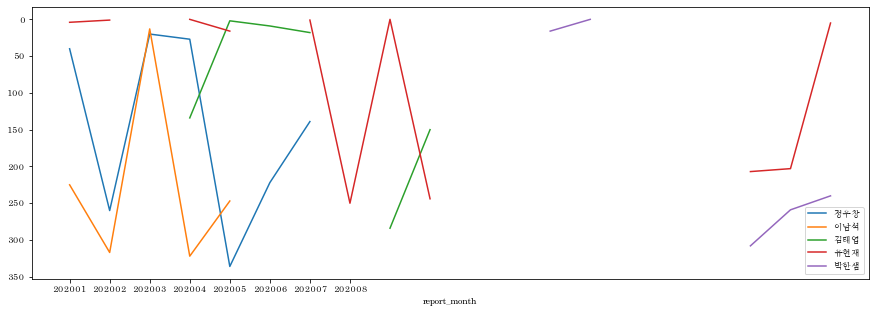

In [203]:
cnt = 0
fig, ax = plt.subplots()
leg = []
for auth in top_performers[:5]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = mon_author_rank_df.loc[mon_author_rank_df['author'] == auth]
    tmp_df.set_index('report_month')['monthly_rank'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    #ax.set_xticklabels(list(valid_df['report_month'].unique()))
    ax.legend(leg)
    if cnt > 10:
        break

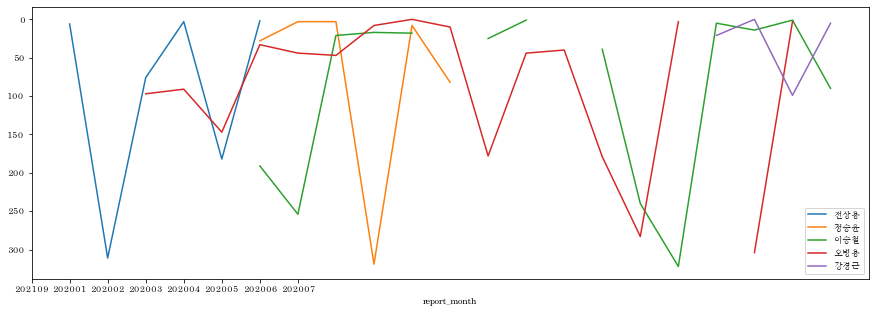

In [204]:
cnt = 0
fig, ax = plt.subplots()
leg = []
for auth in top_performers[5:10]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = mon_author_rank_df.loc[mon_author_rank_df['author'] == auth]
    tmp_df.set_index('report_month')['monthly_rank'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    ax.legend(leg)
    if cnt > 10:
        break

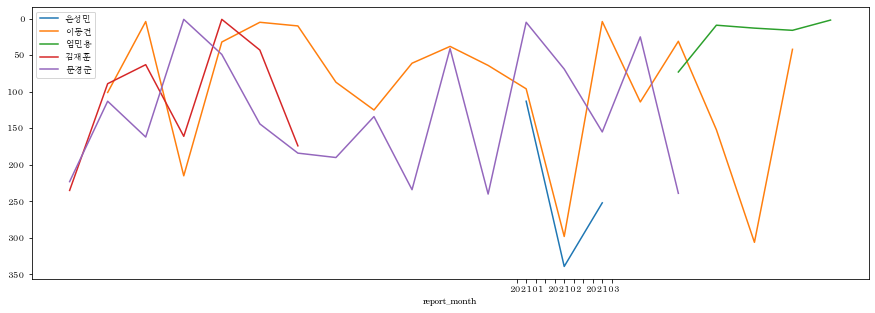

In [205]:
cnt = 0
fig, ax = plt.subplots()
leg = []
for auth in top_performers[10:15]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = mon_author_rank_df.loc[mon_author_rank_df['author'] == auth]
    tmp_df.set_index('report_month')['monthly_rank'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    ax.legend(leg)
    if cnt > 10:
        break

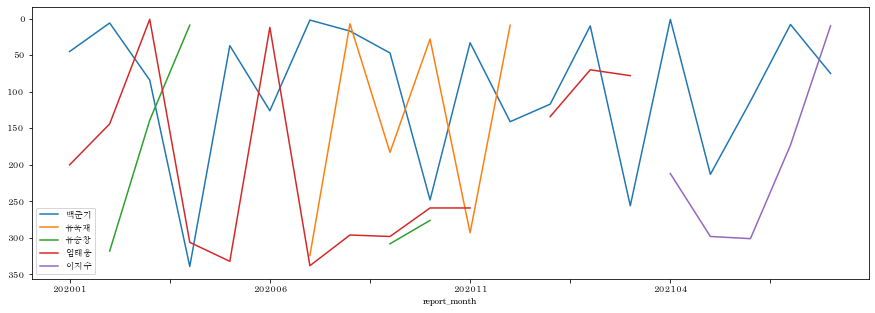

In [206]:
cnt = 0
fig, ax = plt.subplots()
leg = []
for auth in top_performers[15:20]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = mon_author_rank_df.loc[mon_author_rank_df['author'] == auth]
    tmp_df.set_index('report_month')['monthly_rank'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    ax.legend(leg)
    if cnt > 10:
        break

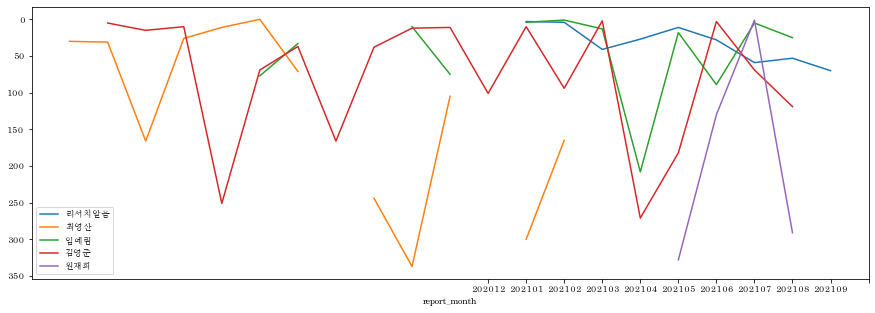

In [207]:
cnt = 0
fig, ax = plt.subplots()
leg = []
for auth in top_performers[20:25]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = mon_author_rank_df.loc[mon_author_rank_df['author'] == auth]
    tmp_df.set_index('report_month')['monthly_rank'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    ax.legend(leg)
    if cnt > 10:
        break